In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:

def get_min_knowns(n):

    rank = 2

    U = np.random.randn(n, rank)
    V = np.random.randn(n, rank)
    original = np.dot(U, V.T)

    for knowns in range(1, n*n):
        threshold = 100

        unknowns = n*n - knowns

        mask = np.array([0] * unknowns + [1] * (n*n - unknowns))
        mask = np.ma.make_mask(mask)

        np.random.shuffle(mask)
        mask = np.reshape(mask, [n,n])

        def line_search(point, grad, obj_func, s = 4, threshold = 1e-10):
            """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """

            choice = point - grad * s
            while obj_func(choice) > obj_func(point):
                s = s / 2
                choice = point - grad * s

            initial_s = s

            while True:
                left = choice + grad * s/2
                right = point - grad * s/2

                s = s / 2
                if obj_func(left) < obj_func(right):
                    choice = left
                else:
                    choice = right

                if np.abs(obj_func(left) - obj_func(right)) < threshold:
                    break

            return (choice, initial_s, s)

        def obj_func(m):
            svd = np.linalg.svd(m, compute_uv=False)

            return np.sum(svd[2:]) 

        def comp_grad(m, boolMask, portion):
            """ Computes gradient that maximizes the objective function """
            epsilon = 1e-3

            grad = np.zeros([n,n])

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j] and np.random.random() > 1 - portion:
                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)

            return grad

        starting_point = np.copy(original)

        boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
        starting_point[boolMask] = 0

        prev_norm = np.linalg.norm(starting_point,'nuc')

        norms = []
        distances = []
        sing_vals = []

        current_point = starting_point

        initial_s = 4
        s = 4
        portion = 1.1
        for i in range(threshold):
            cur_norm = np.linalg.norm(current_point,'nuc')
            norms.append(cur_norm)
            sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
            distances.append(np.linalg.norm(current_point-original,'fro'))
            diff = cur_norm - prev_norm

            #print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'))
            prev_norm = cur_norm
            if diff >= 0 and i > 1:
                break

            ### slowest part of the code ###
            grad = comp_grad(current_point,boolMask, portion)
            current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

        if i == threshold - 1:
            return knowns

In [111]:

def get_min_knowns(n):

    rank = 2

    U = np.random.randn(n, rank)
    V = np.random.randn(n, rank)
    original = np.dot(U, V.T)

    for knowns in range(1, n*n):
        max_steps = 100000
        threshold = 1 # distance between solution and answer when they are considered the same

        unknowns = n*n - knowns

        mask = np.array([0] * unknowns + [1] * (n*n - unknowns))
        mask = np.ma.make_mask(mask)

        np.random.shuffle(mask)
        mask = np.reshape(mask, [n,n])

        
        # First try Newton's method:

        def comp_grad(m, boolMask, obj_func):
            """ Computes gradient that maximizes the objective function """
            epsilon = 1e-3

            # Yes, grad is a vector now
            grad = []

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j] and np.random.random() > 1 - portion:
                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))

            return grad

        def comp_hessian(m, boolMask, of):
            """ Computes hessian (only diagonal) """
            epsilon = 1e-3

            hessian = []

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        row = []

                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        hessian.append((of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2)

            return hessian


        starting_point = np.copy(original)

        boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
        starting_point[boolMask] = 0

        prev_norm = np.linalg.norm(starting_point,'nuc')

        norms = []
        distances = []
        sing_vals = []

        current_point = starting_point

        #pl.imshow(np.abs((current_point-original)/original), cmap=plt.get_cmap('hot'),
        #          interpolation='nearest', vmin=0, vmax=1)
        #pl.colorbar()


        initial_s = 4
        s = 4
        portion = 1.1
        for i in range(max_steps):
            cur_norm = np.linalg.norm(current_point,'nuc')
            norms.append(cur_norm)
            sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
            distances.append(np.linalg.norm(current_point-original,'fro'))
            diff = cur_norm - prev_norm

            # portion really should depend on s since smaller s implies the need of a more accurate gradient estimate
            #portion = 1 - np.exp(-1/(20*s))
            #if i % 1000 == 0:
            #print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'), initial_s, s, portion)
            prev_norm = cur_norm
            
            if np.linalg.norm(current_point-original,'fro') < threshold:
                return knowns
            
            if diff >= 0 and i > 1:
                break

            ### slowest part of the code ###
            descent = np.linalg.lstsq(np.diag(comp_hessian(current_point,boolMask,obj_func)),
               comp_grad(current_point,boolMask,obj_func), rcond=None)[0]

            descent_matrix = np.zeros([n,n])
            count = 0
            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        descent_matrix[i,j] = descent[count]
                        count = count + 1

            reg = 0.39
            next_point = current_point - reg*descent_matrix

            current_point = next_point

        # Next try gradient descent:
        
        def comp_grad(m,boolMask):
            """ Computes gradient that maximizes the objective function """
            epsilon = 1e-3

            grad = np.zeros([n,n])

            for i in range(n):
                for j in range(n):
                    if boolMask[i,j]:
                        diff = np.zeros([n,n])
                        diff[i,j] = epsilon
                        grad[i,j] = (obj_func(m + diff) - obj_func(m - diff))/(2*epsilon)

            return grad
        
        def line_search(point, grad, obj_func, s = 4, threshold = 1e-10):
            """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """

            choice = point - grad * s
            while obj_func(choice) > obj_func(point):
                s = s / 2
                choice = point - grad * s

            initial_s = s

            while True:
                left = choice + grad * s/2
                right = point - grad * s/2

                s = s / 2
                if obj_func(left) < obj_func(right):
                    choice = left
                else:
                    choice = right

                if np.abs(obj_func(left) - obj_func(right)) < threshold:
                    break

            return (choice, initial_s, s)

        starting_point = np.copy(original)

        boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
        starting_point[boolMask] = 0

        prev_norm = np.linalg.norm(starting_point,'nuc')

        norms = []
        distances = []
        sing_vals = []

        current_point = starting_point

        initial_s = 4
        s = 4
        portion = 1.1
        for i in range(threshold):
            cur_norm = np.linalg.norm(current_point,'nuc')
            norms.append(cur_norm)
            sing_vals.append(np.linalg.svd(current_point, compute_uv=False))
            distances.append(np.linalg.norm(current_point-original,'fro'))
            diff = cur_norm - prev_norm

            #print(i, cur_norm, diff, np.linalg.norm(current_point-original,'fro'))
            prev_norm = cur_norm
            
            if np.linalg.norm(current_point-original,'fro') < threshold:
                return knowns
            
            if diff >= 0 and i > 1:
                break

            ### slowest part of the code ###
            grad = comp_grad(current_point,boolMask)
            current_point, initial_s, s = line_search(current_point, grad, obj_func, s = initial_s)

    return False

In [119]:
get_min_knowns(4)

14

In [125]:
n_vals = []
min_knowns_vals = []

for n in range(4,10000):
    min_knowns = get_min_knowns(n)
    if min_knowns:
        n_vals.append(n)
        min_knowns_vals.append(min_knowns)
        print(n, min_knowns)

4 14
6 35
7 47
8 62
9 79
10 78
11 84
12 104
13 113
14 142
15 154
16 185
17 193
18 225
19 230
20 265
21 268
22 266
23 336
24 320
25 334
26 344
27 381
28 404
29 408


KeyboardInterrupt: 

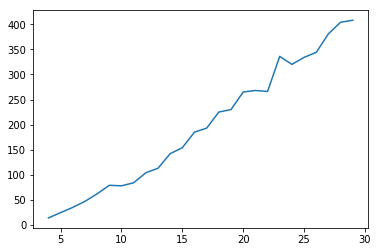

In [126]:
plt.plot(n_vals, min_knowns_vals)

In [128]:
np.save('convergence_n_vals', n_vals)
np.save('convergence_min_known_vals', min_knowns_vals)